#**Twitter Sentiment Analysis Dataset Model Training**

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = ('/content/drive/My Drive/Copy of Sentiment Analysis Dataset.csv')

Mounted at /content/drive


# Import Training Dataset

In [33]:
import csv
tweets = []
sent_label = []
with open (path, encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sent_label.append(row[1])
        tweets.append(row[3])


In [34]:
columns = ['sent_label','tweets']
dataset = pd.DataFrame({'tweets':tweets,'sent_label':sent_label})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578614 entries, 0 to 1578613
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   tweets      1578614 non-null  object
 1   sent_label  1578614 non-null  object
dtypes: object(2)
memory usage: 24.1+ MB


Split dengan rasio 80-20 untuk training

In [35]:
train_dataset = dataset.tweets[:1262890]
test_dataset = dataset.tweets[1262890:]

train_labels = dataset.sent_label[:1262890]
test_labels = dataset.sent_label[1262890:]

In [36]:
train_dataset

0                               is so sad for my APL frie...
1                             I missed the New Moon trail...
2                                    omg its already 7:30 :O
3                    .. Omgaga. Im sooo  im gunna CRy. I'...
4                   i think mi bf is cheating on me!!!   ...
                                 ...                        
1262885    Wedding after parties are so fun with a crazzy...
1262886    wedding day Yeah SUN!  wifes cuz really Nice p...
1262887    Wedding gig in Chattanooga: bad. Getting paid ...
1262888                                    Wedding in a bit 
1262889    Wedding in Jakarta was awesome  Feels great to...
Name: tweets, Length: 1262890, dtype: object

In [37]:
train_labels

0          0
1          0
2          1
3          0
4          0
          ..
1262885    1
1262886    0
1262887    1
1262888    1
1262889    1
Name: sent_label, Length: 1262890, dtype: object

In [38]:
test_dataset

1262890    Wedding is over. Very sweet. But the bride was...
1262891    Wedding pictures for Jen and jeremy  it's a be...
1262892    wedding planning, late into the night... loves...
1262893                                   Wedding reception 
1262894        Wedding shower, lol. Atleast I got free food 
                                 ...                        
1578609                 Zzzzzz.... Finally! Night tweeters! 
1578610                          Zzzzzzz, sleep well people 
1578611              ZzzZzZzzzZ... wait no I have homework. 
1578612        ZzZzzzZZZZzzz meh, what am I doing up again? 
1578613                         Zzzzzzzzzzzzzzzzzzz, I wish 
Name: tweets, Length: 315724, dtype: object

In [39]:
test_labels

1262890    1
1262891    1
1262892    1
1262893    1
1262894    1
          ..
1578609    1
1578610    1
1578611    0
1578612    0
1578613    0
Name: sent_label, Length: 315724, dtype: object

# Pre-processing Training Dataset

Training dataset di normalisasi agar text (corpus) lebih seragam

In [40]:
import string
import re
import os
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples 

tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

stopwords_english = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def process_tweet(tweet):

    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)    
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            tweets_clean.append(word)
    
    return tweets_clean

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Terdapat sebanyak 276226 unique words dari training dataset yang sudah dibersihkan

In [41]:
Vocab = {}
for tweet in train_dataset: 
    processed_tweet = process_tweet(tweet)
    for word in processed_tweet:
        if word not in Vocab: 
            Vocab[word] = len(Vocab)

In [42]:
print(len(Vocab))

276226


Tokenize training dataset menjadi vector

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 276226
embedding_dim = 16
max_length = 140
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok )
tokenizer.fit_on_texts(train_dataset)
dictionary = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_dataset)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_dataset)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

Ubah dataset label menjadi vector representation

In [44]:
train_lab = pd.get_dummies(train_labels).values
test_lab = pd.get_dummies(test_labels).values

In [45]:
train_lab

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

# Model Development

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.GaussianNoise(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.25, 
                                                       recurrent_dropout=0.2,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 16)           4419616   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 140, 16)           0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 140, 16)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 64)           12544     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/TA2_retrain_gitsent_model_checkpoint.hdf5',
                                                monitor='loss', verbose=1, save_best_only=True, mode='auto')

epoch = 8
batch =256
history = model.fit(train_padded, train_lab, epochs=epoch, batch_size=batch,
                    verbose=1,
                    validation_data=(test_padded, test_lab), 
                    shuffle=True, callbacks=[checkpoint])

Epoch 1/8
4934/4934 [==============================] - 4377s 885ms/step - loss: 0.5356 - accuracy: 0.7210 - val_loss: 0.4051 - val_accuracy: 0.8193

Epoch 00001: loss improved from inf to 0.48712, saving model to /content/drive/My Drive/TA2_retrain_gitsent_model_checkpoint.hdf5
Epoch 2/8
4934/4934 [==============================] - 4358s 883ms/step - loss: 0.4296 - accuracy: 0.8010 - val_loss: 0.3938 - val_accuracy: 0.8247

Epoch 00002: loss improved from 0.48712 to 0.42633, saving model to /content/drive/My Drive/TA2_retrain_gitsent_model_checkpoint.hdf5
Epoch 3/8
4934/4934 [==============================] - 4284s 868ms/step - loss: 0.4040 - accuracy: 0.8163 - val_loss: 0.3894 - val_accuracy: 0.8264

Epoch 00003: loss improved from 0.42633 to 0.40201, saving model to /content/drive/My Drive/TA2_retrain_gitsent_model_checkpoint.hdf5
Epoch 4/8
4934/4934 [==============================] - 4270s 865ms/step - loss: 0.3836 - accuracy: 0.8279 - val_loss: 0.3802 - val_accuracy: 0.8317

Epoch 

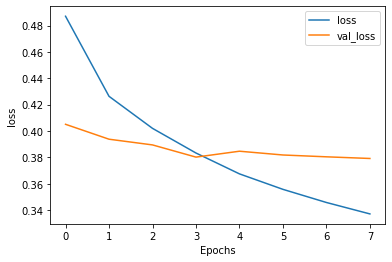

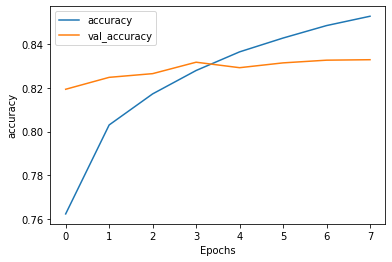

In [ ]:
import matplotlib.pyplot as plt 

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history,"loss")
plot_graphs(history,"accuracy")

# Model Prediction

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/TA2_aftercheckpoint_gitsent_model_checkpoint.hdf5")#load dari checkpoint yang baru, abaikan jika colab tidak disconnected setelah selesai training

In [47]:
trump_dir = '/content/drive/My Drive/TA2/data/predict_data/trump_dataset/Trump-november2020-11-03.csv'
biden_dir = '/content/drive/My Drive/TA2/data/predict_data/biden_dataset/Biden-november2020-11-03.csv'

In [51]:
trump_df = pd.read_csv(trump_dir, encoding='utf8', delimiter=',')
biden_df = pd.read_csv(biden_dir, encoding='utf8', delimiter=',')

In [49]:
trump_df

,created_at,tweet_id,tweet,retweet_count,like_count,quote count,source,verified_stat,username,user_loc,user_created_at
0,2020-11-03 23:59:59+00:00,1323776973500485635,My wife wants to leave the country if Trump wi...,0,4,0,Twitter for iPhone,False,SilvermanCena,NaN,2018-12-19 05:04:22+00:00
1,2020-11-03 23:59:59+00:00,1323776972913192960,Past few days I talked to a couple of acquaint...,0,0,0,Twitter for iPhone,False,BigMacMeek,"California, USA",2012-12-21 06:10:04+00:00
2,2020-11-03 23:59:59+00:00,1323776972405821441,Got home to my stepdad listening to Trump. Sho...,0,0,0,Twitter for iPhone,False,namnado11,"Slidell, LA",2017-03-28 20:32:32+00:00
3,2020-11-03 23:59:59+00:00,1323776972380610561,Omg they are talking on Fox about the boarding...,0,0,0,Twitter Web App,False,cocacolamoon7,Florida Gator Chomp U.S.A. 🐊,2017-08-30 18:19:12+00:00
4,2020-11-03 23:59:59+00:00,1323776972355489796,WAIT....IS TRUMP WINNING?,0,2,0,Twitter for iPhone,False,detectivedelrey,portugal | 24 | she/her,2017-04-21 23:26:52+00:00
...,...,...,...,...,...,...,...,...,...,...,...
14996,2020-11-03 23:24:24+00:00,1323768017566642176,The news said Trump's in the lead so far:(,0,0,0,Twitter for Android,False,rarechvr,dixies basement,2020-04-19 17:55:57+00:00
14997,2020-11-03 23:24:24+00:00,1323768017050689536,Nothing eases my anxiety like watching the @CN...,0,21,0,Twitter for iPhone,False,BlueRobotDesign,United States,2011-05-08 03:40:28+00:00
14998,2020-11-03 23:24:24+00:00,1323768016832704513,"Calling it, Trump landslide",0,0,1,Twitter for Android,False,Deanozord5000,"Hamilton, Scotland",2009-06-27 23:16:51+00:00
14999,2020-11-03 23:24:24+00:00,1323768016216096771,Is anyone getting sick of \n\nWINNING WINNING ...,1,2,0,Twitter for iPhone,False,Qanon454,NaN,2020-03-21 05:22:51+00:00


In [52]:
biden_df

,created_at,tweet_id,tweet,retweet_count,like_count,quote count,source,verified_stat,username,user_loc,user_created_at
0,2020-11-03 23:59:59+00:00,1323776972019957761,After seeing videos of trump supporters haras...,0,1,0,Twitter for iPhone,False,SigTauKevy,"Death Valley, Nevada",2012-08-14 06:59:49+00:00
1,2020-11-03 23:59:58+00:00,1323776969012465665,Where can I find the stats for trump v Biden? ...,0,0,0,Twitter for iPhone,False,_fappuchino,619,2017-02-28 04:20:19+00:00
2,2020-11-03 23:59:58+00:00,1323776967691423744,"Everyone knows that if Biden wins tonight, the...",0,0,0,Twitter for iPhone,False,saabtc69,Out in the open,2014-09-30 02:44:32+00:00
3,2020-11-03 23:59:57+00:00,1323776966189813761,At the top of the hour (1 minute until 7 PM ES...,0,0,0,Twitter Web App,False,trippwhitbeck,A little off-center.,2014-12-04 05:59:40+00:00
4,2020-11-03 23:59:57+00:00,1323776966126948352,🕯 biden will win 🕯,1,8,1,Twitter for iPhone,False,gngrnde,she/her | minor,2018-06-25 00:11:59+00:00
...,...,...,...,...,...,...,...,...,...,...,...
14996,2020-11-03 22:39:04+00:00,1323756608845991937,#EleccionesEEUU #Elections2020 #ElectionDay #E...,0,1,0,Twitter Web App,False,RaulGuillenP,"La Jonquera, Girona",2019-12-07 23:31:49+00:00
14997,2020-11-03 22:39:03+00:00,1323756606870319104,Biden is a vote for sanity. After that we push...,0,2,0,Twitter for iPhone,False,steveivy,Sekrit Lokation,2009-08-30 19:50:32+00:00
14998,2020-11-03 22:39:03+00:00,1323756605582749697,Biden needs 274 electoral college votes to get...,0,0,0,Twitter for Android,False,Nura_arg,Mars,2016-07-09 12:36:19+00:00
14999,2020-11-03 22:39:03+00:00,1323756603783499776,I follow Trump and Biden supporters alike🥰 lol,0,1,0,Twitter for iPhone,False,ItsOlivaa,NaN,2019-09-14 05:58:18+00:00


In [ ]:
trump_tweet = trump_df['tweet']
biden_tweet = biden_df['tweet']

In [ ]:
def clean_tweet(tweet):

    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)    
    tweet = re.sub(r'#', '', tweet)
    
    return(tweet)

In [ ]:
cleaned_trump = []
cleaned_biden = []

for tweet in trump_tweet: 
    cleaned_trump.append(clean_tweet(tweet))

for tweet in biden_tweet:
    cleaned_biden.append(clean_tweet(tweet))  

In [ ]:
tkz_trump = tokenizer.texts_to_sequences(cleaned_trump)
tkz_trump_padded = pad_sequences(tkz_trump, maxlen=max_length, padding='post', truncating='post')

tkz_biden = tokenizer.texts_to_sequences(cleaned_biden)
tkz_biden_padded = pad_sequences(tkz_biden, maxlen=max_length, padding='post', truncating='post')

In [ ]:
prediction_trump = loaded_model.predict(tkz_trump_padded)
prediction_biden = loaded_model.predict(tkz_biden_padded)

In [ ]:
for i in prediction_trump:
  print(i) #Hasil prediksi merupakan vector 

Streaming output truncated to the last 5000 lines.
[0.10261622 0.8978281 ]
[0.5565786 0.4488764]
[0.08904126 0.91055334]
[0.13139555 0.86901397]
[0.95318425 0.04642278]
[0.5061265 0.4935845]
[0.2685304 0.7353261]
[0.37572283 0.6235932 ]
[0.80574065 0.19503695]
[0.9185214  0.08114189]
[0.086831   0.91335344]
[0.02423793 0.97576374]
[0.74247026 0.25922585]
[0.10368645 0.89672494]
[0.81394875 0.18420002]
[0.09938982 0.900419  ]
[0.2555887 0.7439147]
[0.24340817 0.75661826]
[0.18543905 0.8147489 ]
[0.61114633 0.3895681 ]
[0.67818606 0.32206112]
[0.03059486 0.9693407 ]
[0.9734241  0.02641606]
[0.9066225  0.09392914]
[0.1226168  0.87761664]
[0.03757712 0.962535  ]
[0.4472413  0.55512017]
[0.75300807 0.24693906]
[0.55324966 0.44711572]
[0.3709451  0.62991154]
[0.09250224 0.90742505]
[0.10716528 0.8926547 ]
[0.0076783 0.9923665]
[0.03459492 0.965484  ]
[0.09985951 0.8998313 ]
[0.22779527 0.77472574]
[0.26329666 0.7382981 ]
[0.11670017 0.88381493]
[0.68196446 0.3174598 ]
[0.15607756 0.84496546]

In [ ]:
polar_trump = []
polar_biden = []
for i in range(len(prediction_trump)):
    if prediction_trump[i][0] > 0.5:
        polar_trump.append('Negative')
    else:
        polar_trump.append('Positive')

for i in range(len(prediction_biden)):
    if prediction_biden[i][0] > 0.5:
        polar_biden.append('Negative')
    else:
        polar_biden.append('Positive')


In [ ]:
tr_sentiment = pd.DataFrame(trump_df['tweet'])
tr_sentiment['polarity'] = polar_trump

bd_sentiment = pd.DataFrame(biden_df['tweet'])
bd_sentiment['polarity'] = polar_biden

In [ ]:
tr_sentiment

,tweet,polarity
0,My wife wants to leave the country if Trump wi...,Negative
1,Past few days I talked to a couple of acquaint...,Negative
2,Got home to my stepdad listening to Trump. Sho...,Positive
3,Omg they are talking on Fox about the boarding...,Negative
4,WAIT....IS TRUMP WINNING?,Positive
...,...,...
14996,The news said Trump's in the lead so far:(,Negative
14997,Nothing eases my anxiety like watching the @CN...,Positive
14998,"Calling it, Trump landslide",Positive
14999,Is anyone getting sick of \n\nWINNING WINNING ...,Negative


In [ ]:
bd_sentiment

,tweet,polarity
0,After seeing videos of trump supporters haras...,Positive
1,Where can I find the stats for trump v Biden? ...,Negative
2,"Everyone knows that if Biden wins tonight, the...",Positive
3,At the top of the hour (1 minute until 7 PM ES...,Positive
4,🕯 biden will win 🕯,Positive
...,...,...
14996,#EleccionesEEUU #Elections2020 #ElectionDay #E...,Positive
14997,Biden is a vote for sanity. After that we push...,Positive
14998,Biden needs 274 electoral college votes to get...,Positive
14999,I follow Trump and Biden supporters alike🥰 lol,Positive


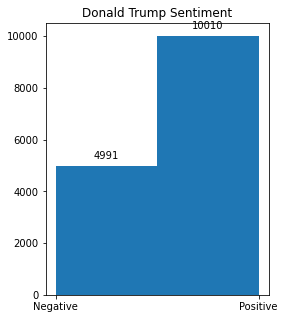

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.hist(tr_sentiment.polarity, bins=2)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
          xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
        
plt.title("Donald Trump Sentiment")
plt.show()

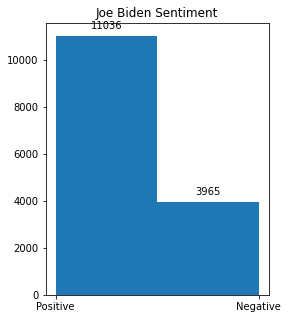

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.hist(bd_sentiment.polarity, bins=2)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
          xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
        
plt.title("Joe Biden Sentiment")
plt.show()

# Word Cloud

In [ ]:
tweet_trump = pd.DataFrame(tr_sentiment['tweet'])
tweet_biden = pd.DataFrame(bd_sentiment['tweet'])

In [ ]:
def to_lower(tweet):
  tweet = tweet.lower()
  tweet =re.sub('\n','', tweet)

  return tweet

In [ ]:
tweet_trump['tweet'] = tweet_trump.tweet.apply(lambda x: to_lower(x))
tweet_biden['tweet'] = tweet_biden.tweet.apply(lambda x: to_lower(x))

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
new_words = ["able","about","above","abroad","according","accordingly","across","actually","adj",
             "after","afterwards","again","against","ago","ahead","ain’t","all","allow","allows",
             "almost","alone","along","alongside","already","also","although","always","am","amid",
             "amidst","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything",
             "anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren’t","around",
             "as","a’s","aside","ask","asking","associated","at","available","away","awfully","back","backward",
             "backwards","be","became","because","become","becomes","becoming","been","before","beforehand",
             "begin","behind","being","believe","below","beside","besides","best","better","between","beyond",
             "both","brief","but","by","came","can","cannot","cant","can’t","caption","cause","causes","certain",
             "certainly","changes","clearly","c’mon","co","co.","com","come","comes","concerning","consequently",
             "consider","considering","contain","containing","contains","corresponding","could","couldn’t","course",
             "c’s","currently","dare","daren’t","definitely","described","despite","did","didn’t","different","directly",
             "do","does","doesn’t","doing","done","don’t","down","downwards","during","each","edu","eg","eight","eighty",
             "either","else","elsewhere","end","ending","enough","entirely","especially","et","etc","even","ever","evermore",
             "every","everybody","everyone","everything","everywhere","ex","exactly","example","except","fairly","far",
             "farther","few","fewer","fifth","first","five","followed","following","follows","for","forever","former",
             "formerly","forth","forward","found","four","from","further","furthermore","get","gets","getting","given","gives",
             "go","goes","going","gone","got","gotten","greetings","had","hadn’t","half","happens","hardly","has","hasn’t","have",
             "haven’t","having","he","he’d","he’ll","hello","help","hence","her","here","hereafter","hereby","herein","here’s",
             "hereupon","hers","herself","he’s","hi","him","himself","his","hither","hopefully","how","howbeit","however",
             "hundred","i’d","ie","if","ignored","i’ll","i’m","immediate","in","inasmuch","inc","inc.","indeed","indicate",
             "indicated","indicates","inner","inside","insofar","instead","into","inward","is","isn’t","it","it’d","it’ll",
             "its","it’s","itself","i’ve","just","k","keep","keeps","kept","know","known","knows","last","lately","later",
             "latter","latterly","least","less","lest","let","let’s","like","liked","likely","likewise","little","look",
             "looking","looks","low","lower","ltd","made","mainly","make","makes","many","may","maybe","mayn’t","me",
             "mean","meantime","meanwhile","merely","might","mightn’t","mine","minus","miss","more","moreover","most",
             "mostly","mr","mrs","much","must","mustn’t","my","myself","name","namely","nd","near","nearly","necessary",
             "need","needn’t","needs","neither","never","neverf","neverless","nevertheless","new","next","nine","ninety",
             "no","nobody","non","none","nonetheless","noone","no-one","nor","normally","not","nothing","notwithstanding",
             "novel","now","nowhere","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","one’s",
             "only","onto","opposite","or","other","others","otherwise","ought","oughtn’t","our","ours","ourselves","out",
             "outside","over","overall","own","particular","particularly","past","per","perhaps","placed","please","plus",
             "possible","presumably","probably","provided","provides","que","quite","qv","rather","rd","re","really","reasonably",
             "recent","recently","regarding","regardless","regards","relatively","respectively","right","round","said","same",
             "saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self",
             "selves","sensible","sent","serious","seriously","seven","several","shall","shan’t","she","she’d","she’ll","she’s",
             "should","shouldn’t","since","six","so","some","somebody","someday","somehow","someone","something","sometime",
             "sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup",
             "sure","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that’ll","thats","that’s",
             "that’ve","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","there’d",
             "therefore","therein","there’ll","there’re","theres","there’s","thereupon","there’ve","these","they","they’d",
             "they’ll","they’re","they’ve","thing","things","think","third","thirty","this","thorough","thoroughly","those",
             "though","three","through","throughout","thru","thus","till","to","together","too","took","toward","towards",
             "tried","tries","truly","try","trying","t’s","twice","two","un","under","underneath","undoing","unfortunately",
             "unless","unlike","unlikely","until","unto","up","upon","upwards","us","use","used","useful","uses","using",
             "usually","v","value","various","versus","very","via","viz","vs","want","wants","was","wasn’t","way","we",
             "we’d","welcome","well","we’ll","went","were","we’re","weren’t","we’ve","what","whatever","what’ll","what’s",
             "what’ve","when","whence","whenever","where","whereafter","whereas","whereby","wherein","where’s","whereupon",
             "wherever","whether","which","whichever","while","whilst","whither","who","who’d","whoever","whole","who’ll",
             "whom","whomever","who’s","whose","why","will","willing","wish","with","within","without","wonder","won’t",
             "would","wouldn’t","yes","yet","you","you’d","you’ll","your","you’re","yours","yourself","yourselves","you’ve",
             "zero","a","how’s","i","when’s","why’s","b","c","d","e","f","g","h","j","l","m","n","o","p","q","r","s","t","u",
             "uucp","w","x","y","z","I","www","amount","bill","bottom","call","computer","con","couldnt","cry","de","describe",
             "detail","due","eleven","empty","fifteen","fifty","fill","find","fire","forty","front","full","give","hasnt",
             "herse","himse","interest","itse”","mill","move","myse”","part","put","show","side","sincere","sixty","system",
             "ten","thick","thin","top","twelve","twenty","abst","accordance","act","added","adopted","affected","affecting",
             "affects","ah","announce","anymore","apparently","approximately","aren","arent","arise","auth","beginning",
             "beginnings","begins","biol","briefly","ca","date","ed","effect","et-al","ff","fix","gave","giving","heres",
             "hes","hid","home","id","im","immediately","importance","important","index","information","invention","itd",
             "keys","kg","km","largely","lets","line","‘ll","means","mg","million","ml","mug","na","nay","necessarily",
             "nos","noted","obtain","obtained","omitted","ord","owing","page","pages","poorly","possibly","potentially",
             "pp","predominantly","present","previously","primarily","promptly","proud","quickly","ran","readily","ref",
             "refs","related","research","resulted","resulting","results","run","sec","section","shed","shes","showed",
             "shown","showns","shows","significant","significantly","similar","similarly","slightly","somethan",
             "specifically","state","states","stop","strongly","substantially","successfully","sufficiently","suggest",
             "thered","thereof","therere","thereto","theyd","theyre","thou","thoughh","thousand","throug","til","tip",
             "ts","ups","usefully","usefulness","‘ve","vol","vols","wed","whats","wheres","whim","whod","whos","widely",
             "words","world","youd","youre","donald","trump","donald trump","amp","biden","joe","trumpdonald", "trump donald", 
             "bidenjoe", "biden joe", "president","people"]
stop_words.extend(new_words)
stop_words = set(stop_words)

In [ ]:
tweet_trump['tweet'] = tweet_trump.tweet.apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
tweet_biden['tweet'] = tweet_biden.tweet.apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

In [ ]:
tweet_trump

,tweet
0,"wife leave country wins, real. fucking crazy"
1,days talked couple acquaintances today’s elect...
2,stepdad listening trump.
3,omg talking fox boarding cities trumps riot. m...
4,wait....is winning?
...,...
14996,news trump's lead far:(
14997,eases anxiety watching @cnn start filing rural...
14998,"calling it, landslide"
14999,sick winning winning winning yeah...neither i....


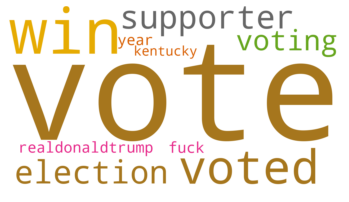

In [ ]:
from wordcloud import WordCloud
text = " ".join(words for words in tweet_trump.tweet)
wordcloud = WordCloud(stopwords=stop_words, width=1600, height=900, background_color="white", 
                       colormap="Dark2", max_font_size=700, random_state=5, max_words=10, collocations=False).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

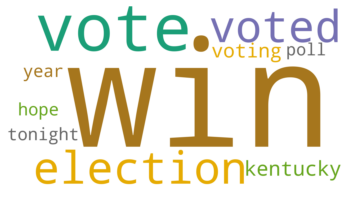

In [ ]:
from wordcloud import WordCloud
text = " ".join(words for words in tweet_biden.tweet)
wordcloud = WordCloud(stopwords=stop_words, width=1600, height=900, background_color="white", 
                       colormap="Dark2", max_font_size=700, random_state=5, max_words=10, collocations=False).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/TA2_gitsent_model_checkpoint.hdf5", 
                                                monitor='loss', verbose=1,
                                                save_best_only=True, mode='auto')
epoch = 8
batch = 64
history = model.fit(train_padded, train_lab, epochs=epoch, batch_size=batch,
                    verbose=1,
                    validation_data=(test_padded, test_lab), 
                    shuffle=True, callbacks=[checkpoint])
#history = model.fit(train_padded, train_labels, epochs=epoch, validation_data=(test_padded, test_labels), verbose=1, shuffle=True)

NameError: ignored

In [ ]:
EDA_trump = t

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/TA2_gitsent_model_checkpoint.hdf5')
np.testing.assert_allclose(model.predict(train_padded), new_model.predict(train_padded),1e-5)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/TA2_aftercheckpoint_gitsent_model_checkpoint.hdf5',
                                                monitor='loss', verbose=1, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint]
new_model.fit(train_padded, train_lab, epochs=epoch, batch_size=batch,
                    verbose=2,
                    validation_data=(test_padded, test_lab), 
                    shuffle=True, callbacks=[checkpoint])


NameError: ignored

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/gitsent_model.h5')